# Expected Returns - Statistical Analysis

The goal is to find some insight into the following questions:
1. Frequency of stocks gaining 1-3% in a day
2. Frequency of stocks gaining 1-3% in a day after an after hours jump
3. Average overall volatility in a stock price. How often does the price vary 1%, 2%, 3% from high to low?
4. How often does a stock jump in the first 15-30 minutes and then end positive/negative?

In [1]:
# Import libraries and set up plotting
import sys
sys.path.append('../scripts/')
import alpaca_trade_api as tradeapi
from helper_functions import *
from cam_paper_keys import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Create function to convert colors: rgb_colors
def rgb_color(r,g,b):
    r = r/255.
    g = g/255.
    b = b/255.
    return(r,g,b)

# Create colors:
tableau_blue = rgb_color(31,119,180)
dark_blue = '#092334'
orange = '#CB6B48'
grey = '#C7C7C7'

In [2]:
# Connect to API and load in SP500 tickers
api = connect_paper_api(paper_key_id, paper_secret_key)
symbols = save_sp500_tickers()

___
## 1. Intraday Gains/Loss Analysis

Our chasing jumps theory is currently based on the assumption that stocks will return **at least** a 1% return throughout the day (i.e from market open to market close). But is this true? Taking it a step further - what is distribution of intraday stock returns for positions in the S&P 500? Let's do some analysis.

Let's begin by pulling in the last 100 days open and close prices for each position in the S&P 500. We can then calculate the intraday return for each day (close-open/open) and then put this return into one of eight groups ('<-3%', '-3%-2%', '-2%-1%', '-1%-0', '0-1%', '1-2%', '2-3%', '> 3%'). With done for all the tickers in the S&P 500, we can find the overall distribution of intraday returns over the last 100 days in all possible stocks that our script would have picked.

In [5]:
returns_dict = dict()
counter = 0
for sym in symbols:
    try:
        hist_data = pull_hist_data(api, sym, '100 days', agg='day')[['open', 'close']]
        hist_data['days_return'] = (hist_data['close'] - hist_data['open'])/hist_data['open']
        hist_data['return_group'] = pd.cut(hist_data['days_return'], [-1, -0.03, -0.02, -0.01, 0,  0.01, 0.02, 0.03, 1], labels=['<-3%', '-3%-2%', '-2%-1%', '-1%-0', '0-1%', '1-2%', '2-3%', '> 3%'])
        returns_dict[sym] = hist_data.groupby('return_group')['close'].count().to_dict()
    except:
        counter += 1
        pass
df_returns = pd.DataFrame.from_dict(returns_dict, orient='index')
print ('Dataframe saved. Data pull issue with {} symbols'.format(counter))

Dataframe saved. Data pull issue with 0 symbols


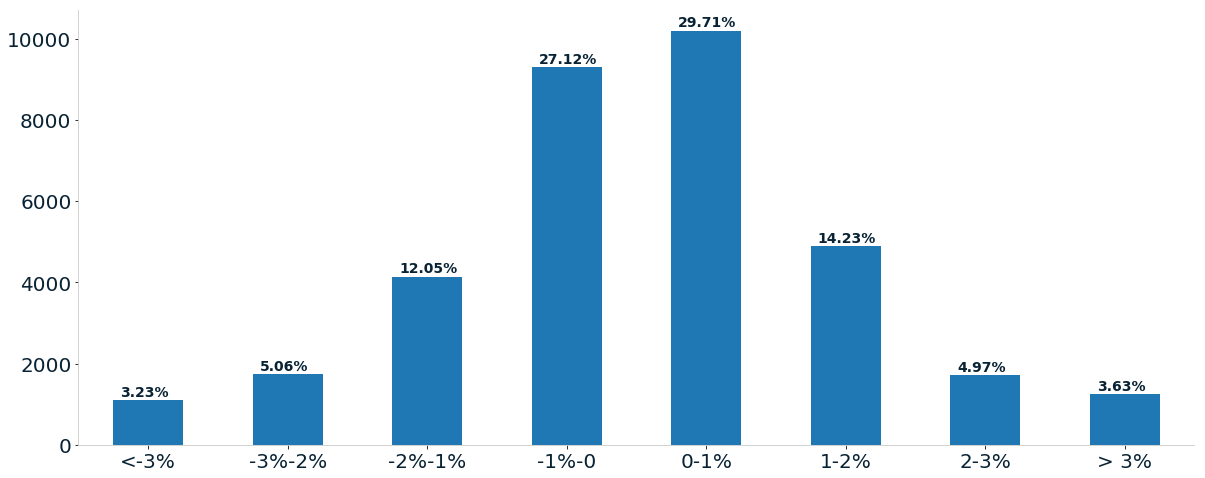

In [6]:
ax = df_returns.sum().plot(kind='bar', legend=False, figsize=(20,8), color=tableau_blue)
for i in range(8):
    pct = (df_returns.sum()/df_returns.sum().sum()).values[i]
    val = df_returns.sum().values[i]
    plt.annotate('{}%'.format(str(round(pct*100, 2))), (i-0.2, val+100), fontsize=14, weight='bold', color=dark_blue)
plt.ylabel('')
plt.yticks(color=dark_blue, fontsize=20)
plt.xticks(rotation=0, color=dark_blue, fontsize=20)
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color(grey) 
ax.spines['left'].set_color(grey)
plt.show()

We can see from the bar chart that the most often intraday return is a return of 0-1% which happens about 29% of the time. This is probably to be expected from our expereince over the last few weeks. The next most likely outcome is a loss of 0-1% at about 26% of the time and again this is not surprising. But what is interesting is this is based on the assumption that we are choosing our stocks **randomly**, or simply put, this is our baseline. If we randomly pick a stock at 9:30 and sell it at the close of the day, we, statiscially speaking, should make 0-1% 29% of the time, lose 0-1% 26% of the time, etc, etc, etc. 

But what about by day? Each day how often do we get positions that grow 1%, 2%, or even 3% plus? Let's find the the returns each day for each symbol in the S&P500 and find the distribution.

In [28]:
matrix = np.zeros((68,8), np.int8)
for sym in symbols:
    try:
        hist_data = pull_hist_data(api, sym, '100 days', agg='day')[['open', 'close']]
        hist_data['days_return'] = (hist_data['close'] - hist_data['open'])/hist_data['open']
        hist_data['return_group'] = pd.cut(hist_data['days_return'], [-1, -0.03, -0.02, -0.01, 0,  0.01, 0.02, 0.03, 1], labels=['<-3%', '-3%-2%', '-2%-1%', '-1%-0', '0-1%', '1-2%', '2-3%', '> 3%'])
        matrix = np.add(matrix, pd.get_dummies(hist_data['return_group']).values)
    except:
        pass
        print('Passing on ', sym)
df_day = pd.DataFrame(matrix, index=hist_data.index, columns=['<-3%', '-3%-2%', '-2%-1%', '-1%-0', '0-1%', '1-2%', '2-3%', '> 3%'])

Passing on  WAB


In [35]:
df_day

,<-3%,-3%-2%,-2%-1%,-1%-0,0-1%,1-2%,2-3%,> 3%
day,,,,,,,,
2018-12-06 00:00:00-05:00,5,8,42,73,125,108,70,73
2018-12-07 00:00:00-05:00,127,132,127,80,32,5,1,0
2018-12-10 00:00:00-05:00,7,32,77,156,137,66,18,11
2018-12-11 00:00:00-05:00,52,116,143,116,64,11,2,0
2018-12-12 00:00:00-05:00,20,24,123,221,87,23,4,2
2018-12-13 00:00:00-05:00,41,47,121,147,93,46,7,2
2018-12-14 00:00:00-05:00,22,44,102,187,110,30,9,0
2018-12-17 00:00:00-05:00,98,104,136,101,48,13,3,1
2018-12-18 00:00:00-05:00,29,58,106,178,101,22,6,4
